In [1]:
###################################################

# Standard library
import time
from functools import partial

# Core scientific stack
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

# Astronomy / cosmology
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo

# Cosmology / large-scale structure
import pyccl as ccl

# Catalog / data access
from crow import mass_proxy

# Arrow / parquet
import pyarrow as pa
import pyarrow.parquet as pq

# MCMC
import emcee


## Loading catalogs. Using CLCosmo_sim database for the matched pairs

In [3]:
from astropy.table import Table
path_to_data = '/sps/lsst/users/ebarroso/CLCosmo_Sim_database/data/'
t_cl_halo_match = Table.read(path_to_data + "matched_pairs_Mfofcut.fits")

Mp, zp = 10**14.3, 0.5
display(t_cl_halo_match)


cat1_id,cat1_z,cat1_ra,cat1_dec,cat1_richness,cat1_richness_err,cat1_id_cg,cat1_ztrue_cg,cat1_p_cg_0,cat1_mt_self,cat1_mt_other,cat1_mt_multi_self,cat1_mt_multi_other,cat1_mt_frac_self,cat1_mt_frac_other,cat1_mt_cross,cat1_mt_frac,cat2_id,cat2_z,cat2_ra,cat2_dec,cat2_mass_fof,cat2_M200c,cat2_skysim_halo_id,cat2_mt_self,cat2_mt_other,cat2_mt_multi_self,cat2_mt_multi_other,cat2_mt_frac_other,cat2_mt_frac_self,cat2_mt_cross,cat2_mt_frac
bytes11,float32,float64,float64,float32,float32,int64,float32,float32,bytes13,bytes13,bytes150,bytes150,float64,float64,bytes13,float64,bytes21,float64,float64,float64,float64,float64,float64,bytes6,bytes6,bytes31,bytes31,float64,float64,bytes6,float64
10,0.5135129,52.520436430812914,-25.717996124671657,190.70665,3.7469666,1312945563,0.51072353,0.79138356,1162500021323,1162500021323,"1162500021323,922700021315,205900021323,417800021323,665600021315,1361100021315,711400021315,80500021323","80500021323,922700021315,205900021323,417800021323,665600021315,1361100021315,711400021315,1162500021323",0.4496726208984491,0.30094043887147337,1162500021323,0.4496726208984491,1162500021323,0.5107235191306336,52.520436430812914,-25.717996124671657,546154289100078.9,326491145207346.5,1156008787323.0,10,10,10,10,0.4496726208984491,0.30094043887147337,10,0.30094043887147337
18,0.5712697,56.920376528125075,-27.20434071042304,179.12813,3.6934361,2000524808,0.5740297,0.99996513,549500032315,549500032315,549500032315,549500032315,0.9421648861882373,0.35064935064935066,549500032315,0.9421648861882373,549500032315,0.5740296938561777,56.920376528125075,-27.20434071042304,1009535371108236.6,645749230889104.2,158908916315.0,18,18,18,18,0.9421648861882373,0.35064935064935066,18,0.35064935064935066
24,1.040338,56.99849698116052,-26.7172081871169,124.02715,2.4172914,2002535198,1.0347759,0.93527913,2554900032241,2554900032241,"2554900032241,1212700032259,3011300032241","2554900032241,1212700032259,3011300032241",0.9468829847683286,0.28444444444444444,2554900032241,0.9468829847683286,2554900032241,1.034775804769664,56.99849698116052,-26.7172081871169,381884526534309.9,383668275413453.56,3667408916241.0,24,24,24,24,0.9468829847683286,0.28444444444444444,24,0.28444444444444444
30,0.63518524,58.56362402841767,-27.429961828331713,167.33603,3.6777163,2000759779,0.6426174,0.9958548,1275900032300,1275900032300,"6600032300,1275900032300,23400032300","6600032300,1275900032300,23400032300",0.9812835255072209,0.2767857142857143,1275900032300,0.9812835255072209,1275900032300,0.6426174147729209,58.56362402841767,-27.429961828331713,388491914052507.06,216337687012597.2,1087308916300.0,30,30,30,30,0.9812835255072209,0.2767857142857143,30,0.2767857142857143
71,0.44230303,58.35519782866568,-26.867687128773035,111.9147,3.366554,2000289335,0.43919736,0.7297119,564000032338,564000032338,"161400032338,359200032338,731900032338,564000032338,778100032338,243000032347","161400032338,359200032338,731900032338,564000032338,778100032338,243000032347",0.5346957617359577,0.2518518518518518,564000032338,0.5346957617359577,564000032338,0.4385807111345399,58.34992458608299,-26.866270557202213,356926172895549.3,322972230485814.1,252508916338.0,71,71,71,71,0.5346957617359577,0.2518518518518518,71,0.2518518518518518
73,0.46697217,57.76575707007693,-28.119101936484828,104.439766,2.9570596,2000290819,0.4680865,0.99970347,459400032338,459400032338,"2200032331,459400032338,980800032331","2200032331,459400032338,980800032331",0.9046435837281485,0.2780612244897959,459400032338,0.9046435837281485,459400032338,0.4680865186324199,57.76575707007693,-28.119101936484828,358202422805633.8,278007164916462.0,175708916338.0,73,73,"73,4848","73,4848",0.9046435837281485,0.2780612244897959,73,0.2780612244897959
109,0.4413634,58.509466974185045,-26.989676182075844,103.49396,3.3524604,2000286447,0.44349608,0.99999905,156700032338,156700032338,"156700032338,433200032355","156700032338,433200032355",0.9589822433529834,0.28672985781990523,156700032338,0.9589822433529834,156700032338,0.

## Mass-Richness

In [5]:
def prior(params):
    if len(params) == 6:
        A, B, C, D, E, F = params
        if -2<C<2 and -2<E<2 and -2<F<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False
    else:
        A, B, C, D = params
        if -2<C<2 and A > 0 and B > 0 and D > 0.0:
            return True
        else:
            return False

In [6]:
from multiprocessing import Pool
richness = 'cat1_richness'
m200c = 'cat2_M200c'
redshift = 'cat1_ztrue_cg'
t_cl_halo_match_mor = t_cl_halo_match[t_cl_halo_match[m200c] > 4e13]
def _ln_L(params, X, a, b, use_correction):
    # 1. Prior Check
    if not prior(params):
        return -np.inf
    
    # 2. Extract Data & Params
    pop, M, z = np.log(X[richness]), X[m200c], X[redshift]
    
    if len(params) == 6:
        A, B, C, D, E, F = params
        mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
        sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    else:
        A, B, C, D = params
        mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
        sigma = D
    
    # 3. Physicality Check (Sigma must be positive for all points)
    if np.any(sigma <= 0):
        return -np.inf
    
    # 4. Standard Log-likelihood calculation
    # Using np.sum for speed and stability
    term1 = -0.5 * np.log(2 * np.pi * sigma**2)
    term2 = -0.5 * ((pop - mean_alpha) / sigma)**2
    ln_L = np.sum(term1 + term2)
    
    # 5. Optional Truncation Correction (Corrected logic)
    if use_correction:
        # P(a < n200 < b) = 0.5 * [erf((log(b)-mu)/(sig*sqrt2)) - erf((log(a)-mu)/(sig*sqrt2))]
        inv_sig_root2 = 1.0 / (sigma * np.sqrt(2))
        def erf_func(val):
            return scipy.special.erf((np.log(val) - mean_alpha) * inv_sig_root2)
        
        prob_in_bin = 0.5 * (erf_func(b) - erf_func(a))
        # Add the log of the normalization to the total likelihood
        ln_L -= np.sum(np.log(np.clip(prob_in_bin, 1e-10, None)))
        
    return ln_L

def MCMC(richesse_bin, redshift_bin, itt, redshift_params=True, correction=True, snr_cut = 0.0):
    a, b = richesse_bin
    c, d = redshift_bin
    
    # Selection
    mask = (t_cl_halo_match_mor[richness] > a) & (t_cl_halo_match_mor[richness] < b) & \
           (t_cl_halo_match_mor[redshift] > c) & (t_cl_halo_match_mor[redshift] < d) 
    X = t_cl_halo_match_mor[mask]
    
    if len(X) < 10: # Safety check for empty bins
        print(f"Warning: Bin {richesse_bin}, {redshift_bin} has only {len(X)} clusters.")
        return {'mean': np.zeros(6 if redshift_params else 4), 'std': np.zeros(6 if redshift_params else 4)}

    ndim = 6 if redshift_params else 4
    nwalkers = 24 # Use a multiple of 2 or 4 for better threading
    
    # Better initialization
    if redshift_params:
        guess = np.array([3.2, 0.8, 0.1, 0.5, 0.01, 0.01])
    else:
        guess = np.array([3.2, 0.8, 0.5, 0.01])
        
    p0 = [guess + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, _ln_L, args=[X, a, b, correction])
    sampler.run_mcmc(p0, itt, progress=True)
    
    # Correct result extraction (Flattening)
    burn_in = int(itt * 0.3)
    unflat_samples = sampler.get_chain(discard=burn_in, flat=False)
    flat_samples = sampler.get_chain(discard=burn_in, flat=True)  
    log_prob_unflat = sampler.get_log_prob(discard=burn_in, flat=False)
    log_prob_flat   = sampler.get_log_prob(discard=burn_in, flat=True)

    idx_best = np.argmax(log_prob_flat)
    theta_best = flat_samples[idx_best]
    
    return {
        'chains': unflat_samples,
        'log_prob': log_prob_unflat,
        'mean': np.mean(flat_samples, axis=0),
        'median': np.median(flat_samples, axis=0),
        'std': np.std(flat_samples, axis=0),
        'map': theta_best
    }

### Unbinned

100%|██████████| 10000/10000 [03:57<00:00, 42.06it/s]


A: mean=3.3551, std=0.0116
B: mean=1.0238, std=0.0175
C: mean=0.0333, std=0.0581
D: mean=0.5405, std=0.0071


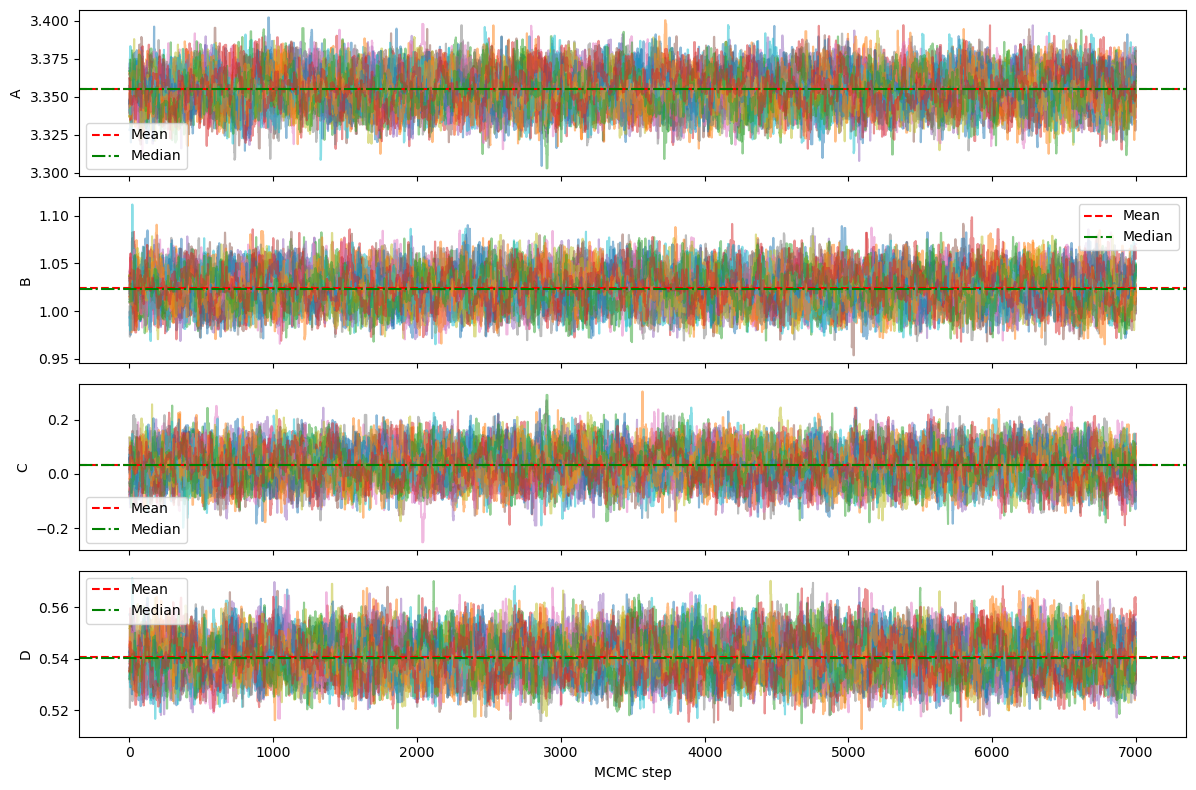

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

res = MCMC(richesse_bin=(10,400), 
           redshift_bin=(0.2,1.0), 
           itt=10000, redshift_params=False, correction=True, snr_cut = 0.0)

# Extract chains and statistics
chains = res['chains']  # shape: (nsteps, nwalkers, 6) or similar
means = res['mean']     # length 6
stds  = res['std']      # length 6

# Print best-fit values
param_names = ['A','B','C','D']
for i, name in enumerate(param_names):
    print(f"{name}: mean={means[i]:.4f}, std={stds[i]:.4f}")

# ------------------------------------------------------------------------------
# Plot chains to check convergence
# ------------------------------------------------------------------------------
n_params = 4
nsteps, nwalkers = chains.shape[0], chains.shape[1]

fig, axes = plt.subplots(n_params, 1, figsize=(12, 2*n_params), sharex=True)
for i in range(n_params):
    ax = axes[i]
    for w in range(nwalkers):
        ax.plot(chains[:, w, i], alpha=0.5)
    # Show mean and median lines
    mean_i = np.mean(chains[:, :, i])
    median_i = np.median(chains[:, :, i])
    ax.axhline(mean_i, color='red', linestyle='--', label='Mean')
    ax.axhline(median_i, color='green', linestyle='-.', label='Median')
    ax.set_ylabel(param_names[i])
    ax.legend()
axes[-1].set_xlabel('MCMC step')
plt.tight_layout()
plt.show()


In [16]:
import os
values = res['map']

# Safety check
if len(values) != 4:
    raise ValueError("Expected 4 parameters: mu_0, mu_1, mu_2, sigma")

output_path = os.path.join(os.getcwd(), "mor_best_fit_map.txt")

with open(output_path, "w") as f:
    f.write("# Best-fit MAP parameters\n")
    f.write("# mu_0   mu_1   mu_2   sigma\n")
    f.write(f"{values[0]:.8e}  {values[1]:.8e}  {values[2]:.8e}  {values[3]:.8e}\n")

print(f"Saved to: {output_path}")

Saved to: /sps/lsst/users/ebarroso/CLPipeline/examples/cosmodc2_redmapper/mor_best_fit_map.txt


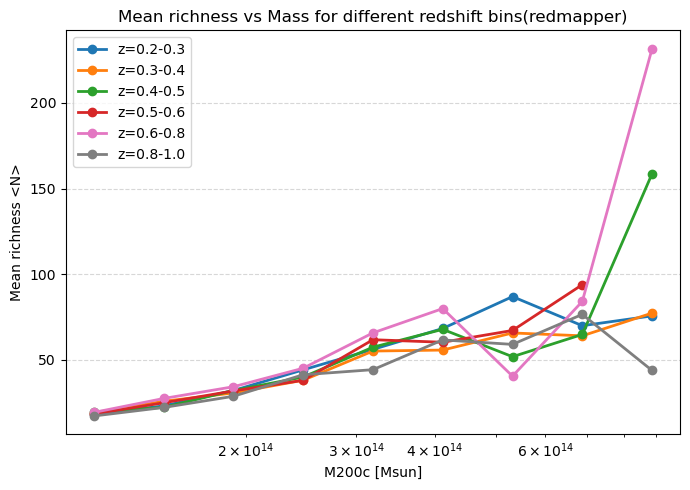

In [9]:
# --- Define redshift bins ---
z_bins = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
z_labels = ["0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.8", "0.8-1.0"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:pink", "tab:gray"]

# --- Define mass bins ---
mass_bins = np.logspace(14, 15, 10)  # e.g., 1e14 to 1e15 in 5 bins
mass_centers = 0.5 * (mass_bins[1:] + mass_bins[:-1])

plt.figure(figsize=(7,5))

# Loop over redshift bins
for zmin, zmax, color, zlabel in zip(z_bins[:-1], z_bins[1:], colors, z_labels):
    mean_richness = []
    
    mask_z = (t_cl_halo_match[redshift] >= zmin) & (t_cl_halo_match[redshift] < zmax)
    
    # Loop over mass bins
    for mmin, mmax in zip(mass_bins[:-1], mass_bins[1:]):
        mask_mass = (t_cl_halo_match[m200c] >= mmin) & (t_cl_halo_match[m200c] < mmax)
        mask = mask_z & mask_mass
        rich_data = t_cl_halo_match[richness][mask]
        
        if len(rich_data) == 0:
            mean_richness.append(np.nan)
        else:
            mean_richness.append(np.mean(rich_data))
    
    plt.plot(mass_centers, mean_richness, marker='o', lw=2, color=color, label=f"z={zlabel}")

plt.xscale('log')
plt.xlabel("M200c [Msun]")
plt.ylabel("Mean richness <N>")
plt.title("Mean richness vs Mass for different redshift bins(redmapper)")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## Testing Best Fit

A: MAP = 3.35519
B: MAP = 1.02355
C: MAP = 0.03724
D: MAP = 0.54010
14.300000000000002


/tmp/ipykernel_3012/1169857266.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


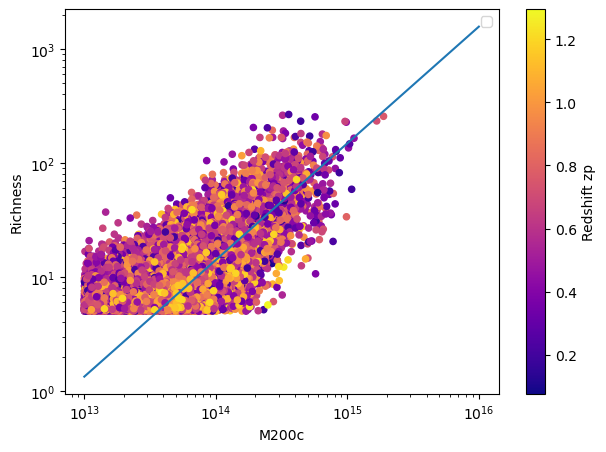

In [10]:
from crow import mass_proxy

logp = res['log_prob']
i, j = np.unravel_index(np.argmax(logp), logp.shape)
best_fit = res["map"]
for name, val in zip(param_names, best_fit):
    print(f"{name}: MAP = {val:.5f}")
mass_richness_unb = mass_proxy.MurataUnbinned(np.log10(Mp), zp)
best_fit_constantin = [3.35, 2.23 / np.log(10), 0.06, 0.56, 0.10/np.log(10), -0.05]
print(np.log10(np.exp(mass_richness_unb.pivot_ln_mass)))
mass_richness_unb.parameters["mu0"] = best_fit[0]
mass_richness_unb.parameters["mu1"] = best_fit[1]
mass_richness_unb.parameters["mu2"] = best_fit[2]
mass_richness_unb.parameters["sigma0"] = best_fit[3]
mass_richness_unb.parameters["sigma1"] = 0.0
mass_richness_unb.parameters["sigma2"] = 0.0

plt.figure(figsize=(7,5))

sc = plt.scatter(
    t_cl_halo_match[m200c],
    t_cl_halo_match[richness],
    c=t_cl_halo_match[redshift],
    cmap='plasma',
    s=20
)
# sc = plt.scatter(
#     t_cl_halo_match['m200c'],
#     t_cl_halo_match['n200'],
#     c=t_cl_halo_match['zp'],
#     cmap='viridis',
#     s=20
# )
rich_plot = np.linspace(np.log10(20),5, 200)
mass_plot = np.linspace(13, 16, 200)
mean = mass_richness_unb.get_ln_mass_proxy_mean(mass_plot, np.array([0.4]))

plt.colorbar(sc, label="Redshift zp")
plt.xlabel("M200c")
plt.ylabel("Richness")
plt.legend()
plt.plot(10**mass_plot, np.exp(mean))
plt.xscale('log')
plt.yscale('log')
plt.show()



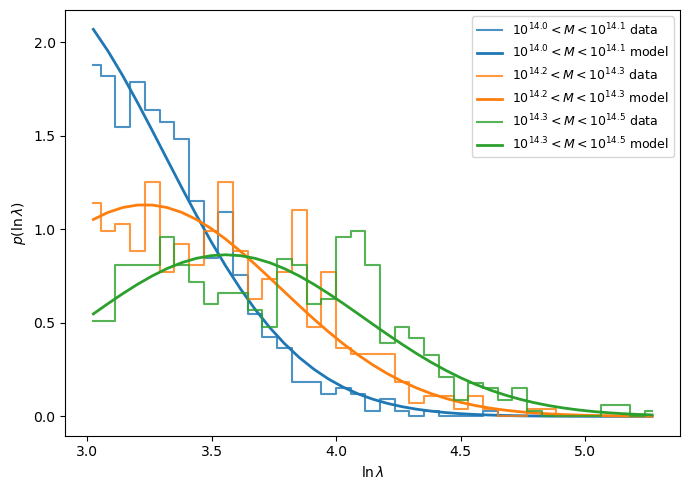

0.8292554948056141
0.984320557491289


In [11]:
mass_bins = [
    (10**14.0, 10**14.1),
    (10**14.2, 10**14.3),
    (10**14.3, 10**14.5),
]

colors = ["tab:blue", "tab:orange", "tab:green"]

plt.figure(figsize=(7,5))

for (mmin, mmax), col in zip(mass_bins, colors):

    mask = (
        (t_cl_halo_match[m200c] > mmin) &
        (t_cl_halo_match[m200c] < mmax) &
        (t_cl_halo_match[redshift] > 0.2) &
        (t_cl_halo_match[redshift] < 1.0)
    )

    rich_data = t_cl_halo_match[richness][mask]
    z_data    = t_cl_halo_match[redshift][mask]
    M_data    = t_cl_halo_match[m200c][mask]


    # Histogram in ln λ
    bins = np.linspace(np.log(20), np.log(200), 40)
    hist, edges = np.histogram(np.log(rich_data), bins=bins, density=True)
    centers = 0.5 * (edges[1:] + edges[:-1])

    # Forward model averaged over objects in the bin
    pdf = []
    for lnlam in centers:
        log10lam = lnlam / np.log(10)

        vals = mass_richness_unb.distribution(
                  np.log10(M_data),
                  z_data,
                  np.full_like(M_data, log10lam)
               )

        pdf.append(np.mean(vals))

    pdf = np.array(pdf)

    label = fr"$10^{{{np.log10(mmin):.1f}}} < M < 10^{{{np.log10(mmax):.1f}}}$"

    plt.step(centers, hist/np.trapezoid(hist, centers), where='mid',
             color=col, alpha=0.8, label=label + " data")

    plt.plot(centers, pdf/np.trapezoid(pdf, centers),
             color=col, lw=2, label=label + " model")


plt.xlabel(r"$\ln \lambda$")
plt.ylabel(r"$p(\ln \lambda)$")
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()
print(np.trapezoid(pdf, centers))
print(np.trapezoid(hist, centers))


In [70]:
import numpy as np
import pyarrow.parquet as pq


import pandas as pd



cluster_catalo_redmapper = pd.read_pickle(path_to_data + "lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl")
#display(cluster_catalo_redmapper)
# 1. Define bins
richness_bins_linear = [20, 35, 70, 100, 200]

# We bin in log10 space
richness_bins_log = np.log10(richness_bins_linear)


# 3. Process data into numpy
# Converting directly to log10 here avoids creating a third massive array
print("Converting richness to log10...")
log10_richness_data = np.log10(cluster_catalo_redmapper['richness'])
redshift_data = cluster_catalo_redmapper['redshift']


# 4. Compute 2D Histogram
print("Computing 2D histogram...")
counts, z_edges, l_edges = np.histogram2d(
    redshift_data,
    log10_richness_data,  
    bins=[z_bins, richness_bins_log]
)
print(l_edges)
# 5. Save to TXT
header = (f"Richness_bins_log_edges: {richness_bins_log}\n"
          f"Redshift_bins_edges: {z_bins}\n"
          "Rows: Richness bins | Cols: Redshift bins")


print(counts)
print(len(counts))

Converting richness to log10...
Computing 2D histogram...
[1.30103    1.54406804 1.84509804 2.         2.30103   ]
[[142.  73.  14.   6.]
 [255. 104.  13.   6.]
 [305. 137.  17.  17.]
 [362. 122.  19.  12.]
 [377. 153.  31.  14.]
 [312. 139.  21.   7.]]
6


In [71]:
from astropy.io import fits
from scipy import stats
from typing import Any
import sacc
import itertools
area = 439.78986
covariance = np.diag(counts.flatten())
s_count = sacc.Sacc()
bin_z_labels = []
bin_richness_labels = []

survey_name = "cosmodc2_redmapper"
s_count.add_tracer("survey", survey_name, area)

for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
    lower, upper = z_bin
    bin_z_label = f"bin_z_{i}"
    s_count.add_tracer("bin_z", bin_z_label, lower, upper)
    bin_z_labels.append(bin_z_label)

for i, richness_bin in enumerate(zip(l_edges[:-1], l_edges[1:])):
    lower, upper = richness_bin
    bin_richness_label = f"rich_{i}"
    s_count.add_tracer("bin_richness", bin_richness_label, lower, upper)
    bin_richness_labels.append(bin_richness_label)

#  pylint: disable-next=no-member
cluster_count = sacc.standard_types.cluster_counts

counts_and_edges = zip(
    counts.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)
print(counts)

for counts_i, (bin_z_label, bin_richness_label) in counts_and_edges:
    s_count.add_data_point(
        cluster_count, (survey_name, bin_richness_label, bin_z_label), int(counts_i)
    )
s_count.add_covariance(covariance)
s_count.to_canonical_order()
#s_count.save_fits("./outputs/clusters_sacc_file_cov.sacc", overwrite=True)
s_count.save_fits("./cosmodc2_redmapper_counts/clusters_sacc_file.sacc", overwrite=True)
print(s_count.data)

[[142.  73.  14.   6.]
 [255. 104.  13.   6.]
 [305. 137.  17.  17.]
 [362. 122.  19.  12.]
 [377. 153.  31.  14.]
 [312. 139.  21.   7.]]
[DataPoint(data_type='cluster_counts', tracers=('cosmodc2_redmapper', 'rich_0', 'bin_z_0'), value=142, ), DataPoint(data_type='cluster_counts', tracers=('cosmodc2_redmapper', 'rich_0', 'bin_z_1'), value=255, ), DataPoint(data_type='cluster_counts', tracers=('cosmodc2_redmapper', 'rich_0', 'bin_z_2'), value=305, ), DataPoint(data_type='cluster_counts', tracers=('cosmodc2_redmapper', 'rich_0', 'bin_z_3'), value=362, ), DataPoint(data_type='cluster_counts', tracers=('cosmodc2_redmapper', 'rich_0', 'bin_z_4'), value=377, ), DataPoint(data_type='cluster_counts', tracers=('cosmodc2_redmapper', 'rich_0', 'bin_z_5'), value=312, ), DataPoint(data_type='cluster_counts', tracers=('cosmodc2_redmapper', 'rich_1', 'bin_z_0'), value=73, ), DataPoint(data_type='cluster_counts', tracers=('cosmodc2_redmapper', 'rich_1', 'bin_z_1'), value=104, ), DataPoint(data_type='

In [72]:
# Imports
import time
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from scipy.interpolate import interp1d

from crow import ClusterShearProfile
from crow import ClusterAbundance
from crow.recipes.binned_exact import ExactBinnedClusterRecipe
from crow.recipes.binned_grid import GridBinnedClusterRecipe
from crow import completeness_models, mass_proxy, purity_models, kernel
from crow.properties import ClusterProperty

# ---- Core cosmology and HMF (same numbers as your example) ----
hmf = ccl.halos.MassFuncDespali16(mass_def="200c")

cosmo = ccl.Cosmology(
    Omega_c=0.1109 / 0.71**2,
    Omega_b=0.02258 / 0.71**2,
    h=0.71,
    n_s=0.963,
    sigma8=0.8,
    w0=-1.0,
    wa=0.0,
    transfer_function="boltzmann_camb"
)

# ---- Common grid / binning parameters for later cells ----
mass_grid_size = 80
redshift_grid_size = 40
proxy_grid_size = 40
sky_area = 440
mass_interval = (12.5, 16.0)


cl_abundandce = ClusterAbundance(cosmo, hmf)

[(np.float64(0.2), np.float64(0.3)), (np.float64(0.3), np.float64(0.4)), (np.float64(0.4), np.float64(0.5)), (np.float64(0.5), np.float64(0.6)), (np.float64(0.6), np.float64(0.7)), (np.float64(0.7), np.float64(0.8))]


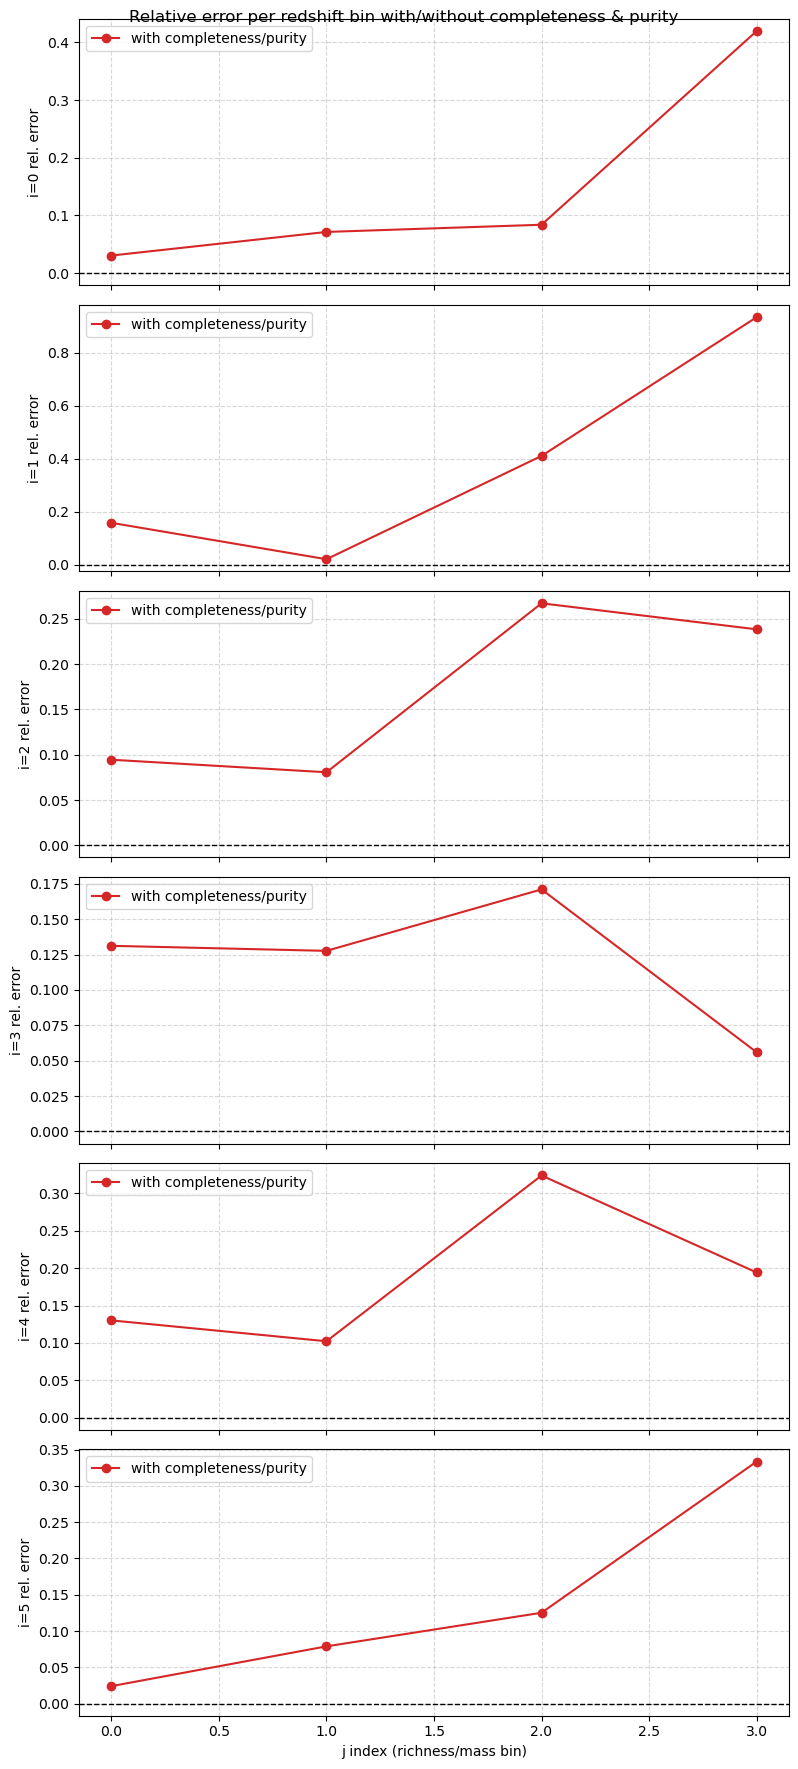

[[137.66947041  67.78753615  12.82570732   8.51718798]
 [214.53179862 101.79491872  18.34603924  11.6097996 ]
 [276.18894308 125.9540566   21.53999506  12.9480642 ]
 [314.51559642 137.56877216  22.2499328   12.67155996]
 [327.96473686 137.37269143  20.95242431  11.28102134]
 [319.51995651 128.03016994  18.37013642   9.33465196]] [[142.  73.  14.   6.]
 [255. 104.  13.   6.]
 [305. 137.  17.  17.]
 [362. 122.  19.  12.]
 [377. 153.  31.  14.]
 [312. 139.  21.   7.]]


In [73]:
purity_aguena = purity_models.PurityAguena16()
completeness_aguena = completeness_models.CompletenessAguena16()

z_bins_tuple = [(z_edges[i], z_edges[i+1]) for i in range(len(z_bins) -1)]
proxy_bins = [(l_edges[i], l_edges[i+1]) for i in range(len(richness_bins_linear) - 1)]
redshift_distribution = kernel.SpectroscopicRedshift()

# --- Fiducial grid with completeness & purity ---
recipe_grid_comp = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_abundandce,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_richness_unb,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
    purity=purity_aguena,
    completeness=completeness_aguena
)
recipe_grid_comp.setup()
print(z_bins_tuple)
grid_comp_vals  = np.zeros((len(z_bins)-1, len(richness_bins_linear)-1))
for i, zb in enumerate(z_bins_tuple):
    for j, pb in enumerate(proxy_bins):
        grid_comp_vals[i,j] = recipe_grid_comp.evaluate_theory_prediction_counts(np.array(zb), np.array(pb), sky_area)

rel_error_matrix = abs(1 - grid_comp_vals / counts)


# --- Plot both relative errors ---
n_i, n_j = rel_error_matrix.shape

fig, axes = plt.subplots(n_i, 1, figsize=(8, 3*n_i), sharex=True)

if n_i == 1:
    axes = [axes]  # make iterable if only 1 subplot

for i in range(n_i):
    axes[i].plot(np.arange(n_j), rel_error_matrix[i], marker='o', linestyle='-', color='tab:red', label="with completeness/purity")
    axes[i].axhline(0, color='k', linestyle='--', lw=1)
    axes[i].set_ylabel(f"i={i} rel. error")
    axes[i].grid(True, ls="--", alpha=0.5)
    axes[i].legend()

axes[-1].set_xlabel("j index (richness/mass bin)")
plt.suptitle("Relative error per redshift bin with/without completeness & purity")
plt.tight_layout()
plt.show()
print(grid_comp_vals, counts)


In [74]:
## Test Shear Profile

[np.float64(0.5572594390625522), np.float64(0.6800364734917794), np.float64(0.8307728756540614), np.float64(1.014633817831334), np.float64(1.238466768049785), np.float64(1.5122109315267438), np.float64(1.846485541628821), np.float64(2.2547756149753497), np.float64(2.7528669882823658), np.float64(3.361445830869178), np.float64(4.10442298604483), np.float64(5.011473048505655), np.float64(6.118889909615353), np.float64(7.471226709680845), np.float64(9.123408642881603)]


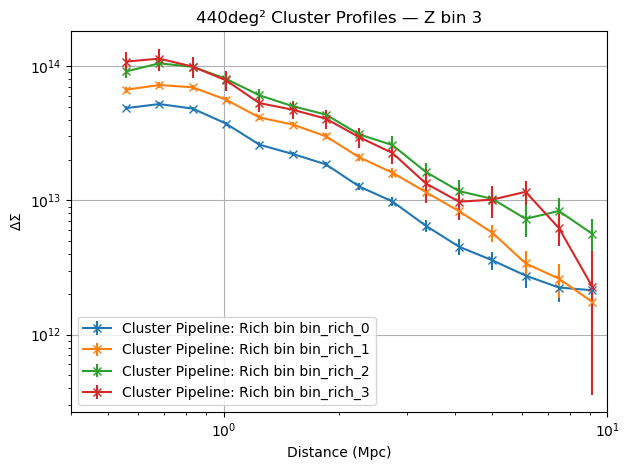

In [76]:
import sacc
import matplotlib.cm as cm
import matplotlib.colors as mcolors

t1 = sacc.Sacc.load_fits("/sps/lsst/users/ebarroso/CLPipeline/examples/cosmodc2_redmapper/cosmodc2_redmapper_full_analysis/outputs_mor/clusters_sacc_file_cov.sacc")

# Color map to ensure consistent color across both plots
cmap = plt.get_cmap('tab10')  # Or use the same cmap as your SACC plots

z_bin_index = 2  # Third z-bin
zbin = 'bin_z_2'
# Begin loop over richness bins
for rich_bin_index in range(4):
    rich_bin = f'bin_rich_{rich_bin_index}'
    color = cmap(rich_bin_index)  # Get consistent color per bin

    data_true = []
    data_true_error = []

    radius_vals = []

    for i in range(15):
        radius_key = f'radius_{i}'
        trac = ('cosmodc2_redmapper', rich_bin, zbin, radius_key)
        radius = t1.tracers[radius_key].center
        radius_vals.append(radius)
        data_true.append(t1.get_data_points(sacc.data_types.standard_types.cluster_delta_sigma, trac)[0].value)
        false_index = t1.indices(sacc.data_types.standard_types.cluster_delta_sigma, trac)
        data_true_error.append(np.sqrt(t1.covariance.covmat[false_index][:, false_index][0, 0]))

    # Plot SACC profile
    plt.errorbar(
        radius_vals, data_true, yerr=data_true_error,
        label=f'Cluster Pipeline: Rich bin {rich_bin}', marker='x', color=color, linestyle='-'
    )
print(radius_vals)
plt.xlabel('Distance (Mpc)')
plt.ylabel(r'$\Delta \Sigma$')
plt.title(f'440deg² Cluster Profiles — Z bin {z_bin_index + 1}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.4, 10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[(np.float64(0.2), np.float64(0.3)), (np.float64(0.3), np.float64(0.4)), (np.float64(0.4), np.float64(0.5)), (np.float64(0.5), np.float64(0.6)), (np.float64(0.6), np.float64(0.7)), (np.float64(0.7), np.float64(0.8))]
15


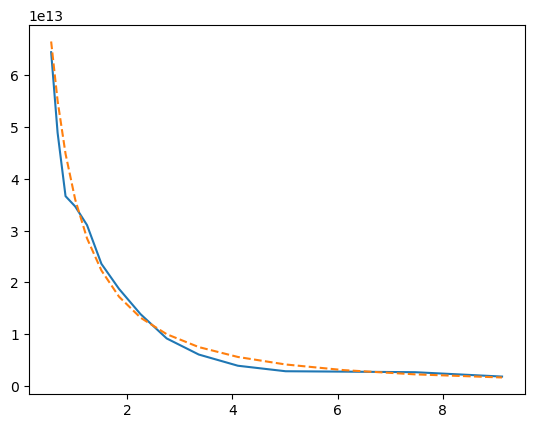

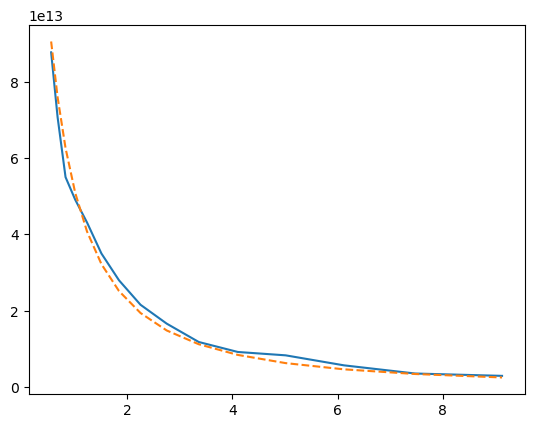

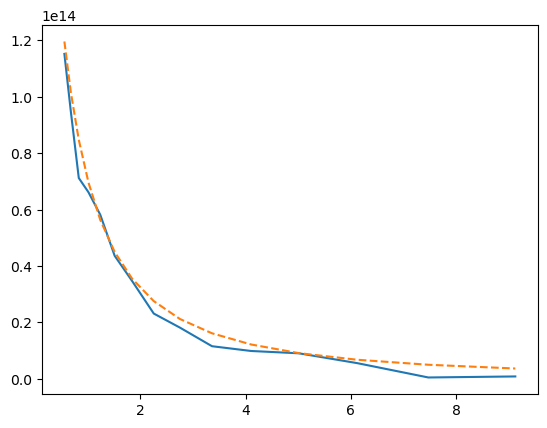

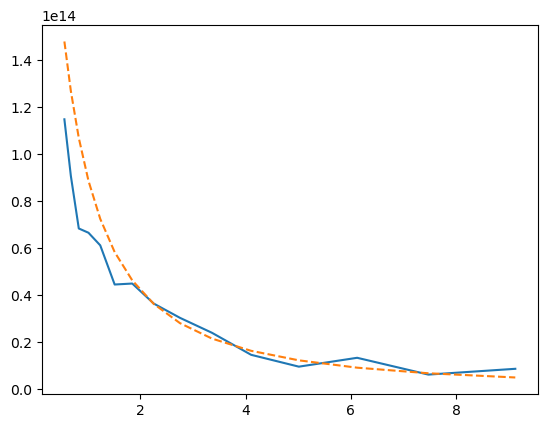

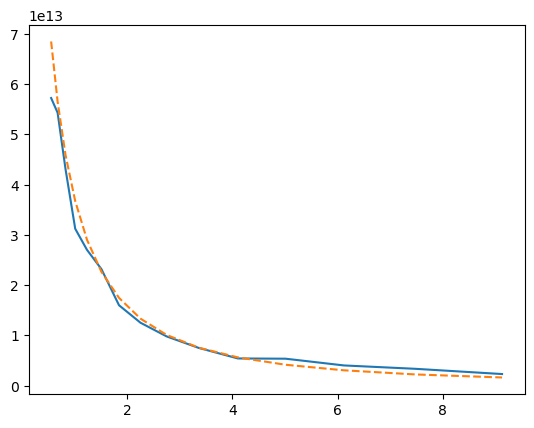

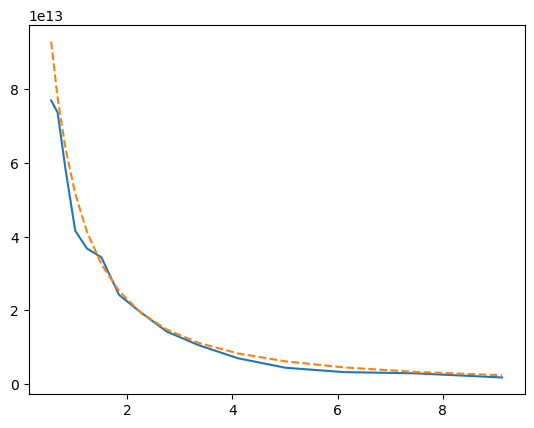

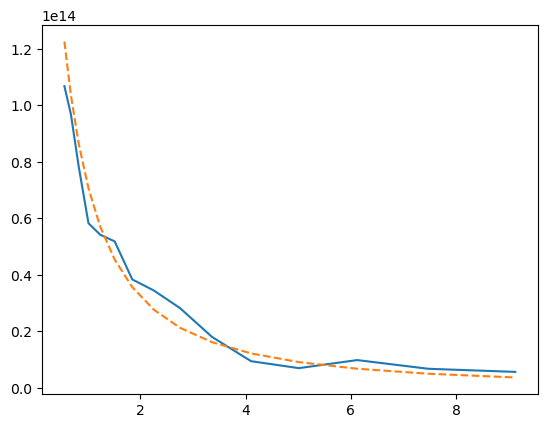

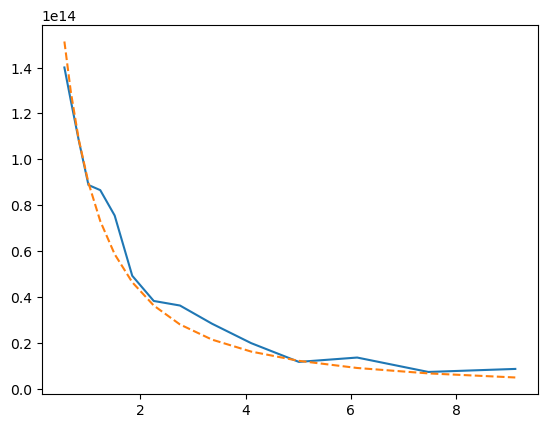

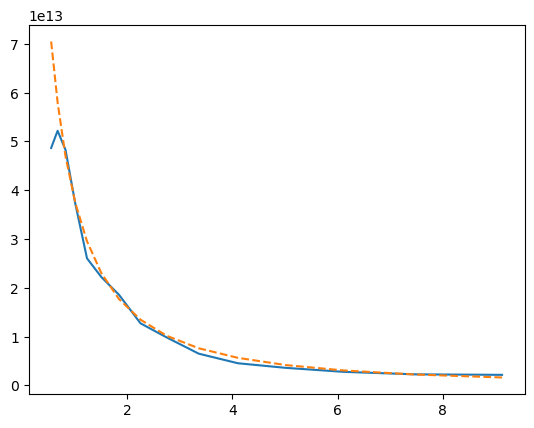

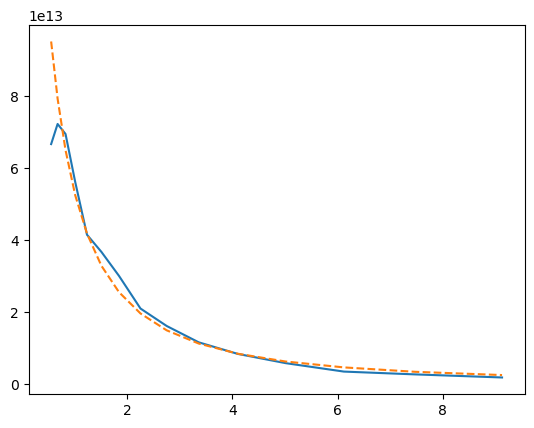

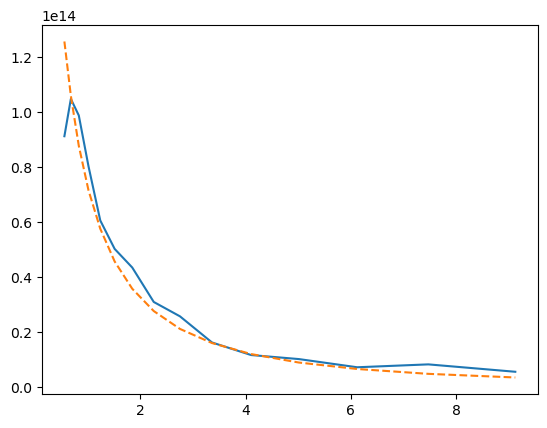

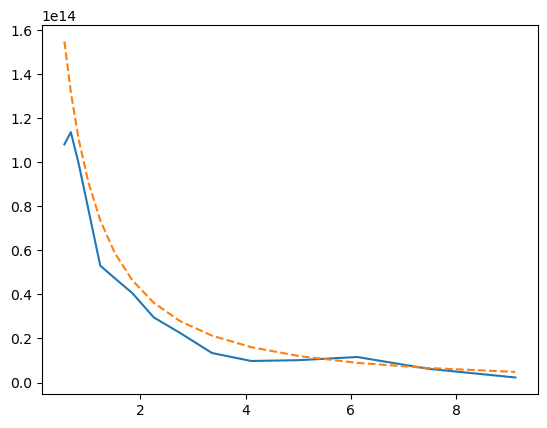

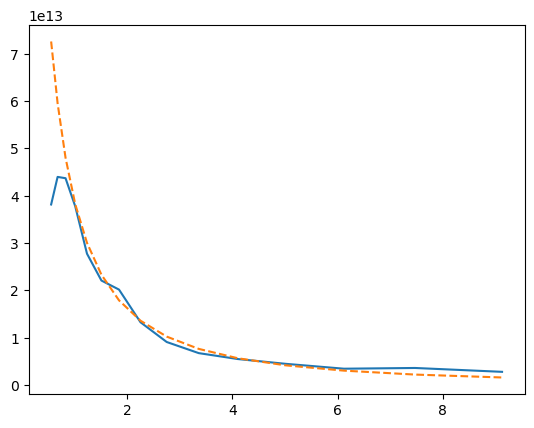

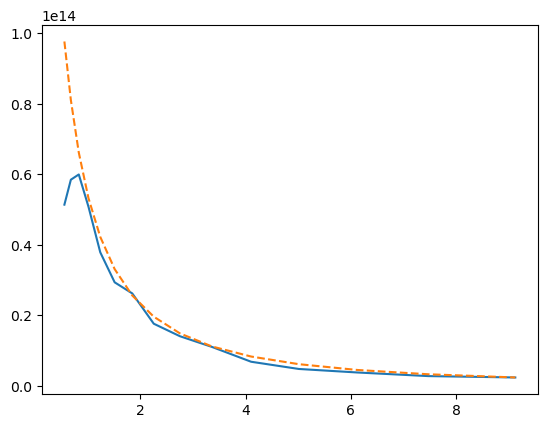

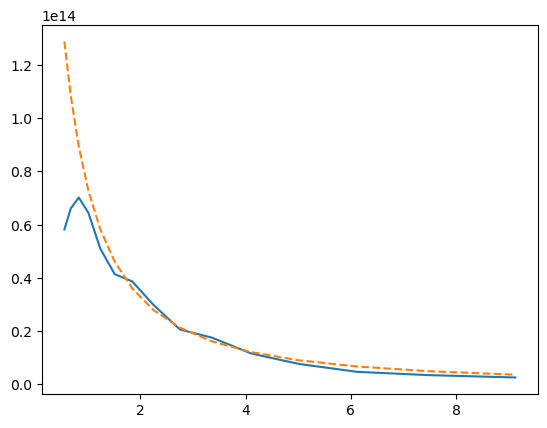

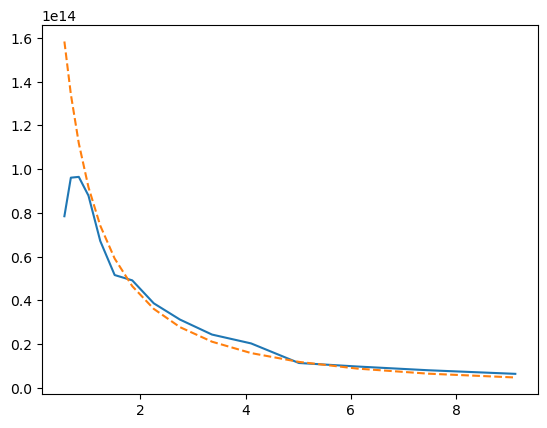

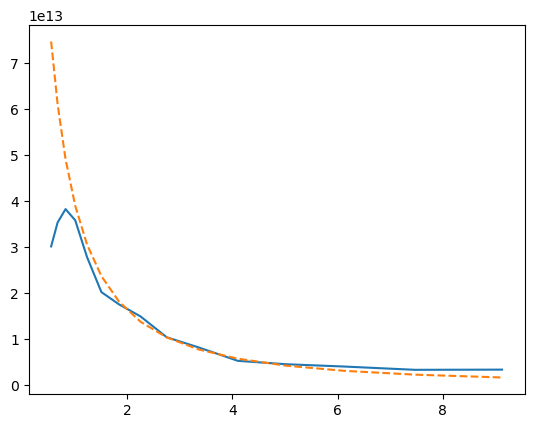

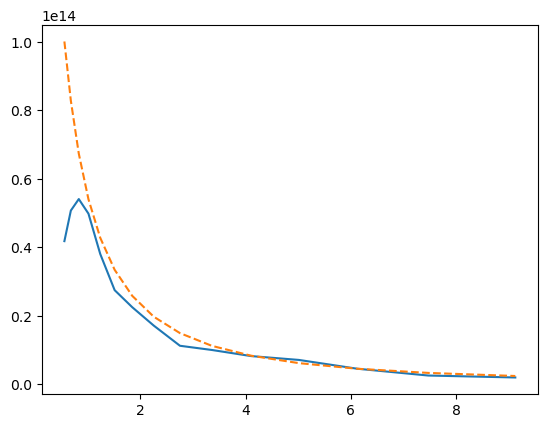

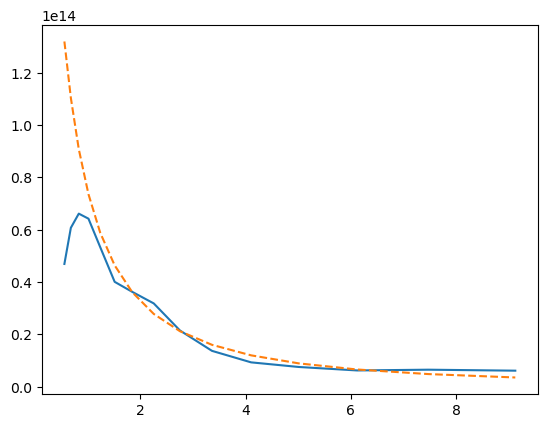

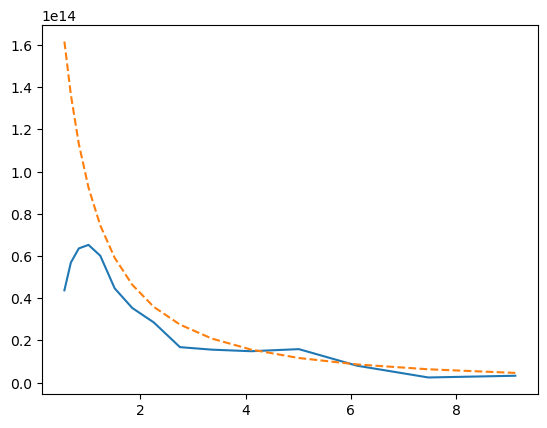

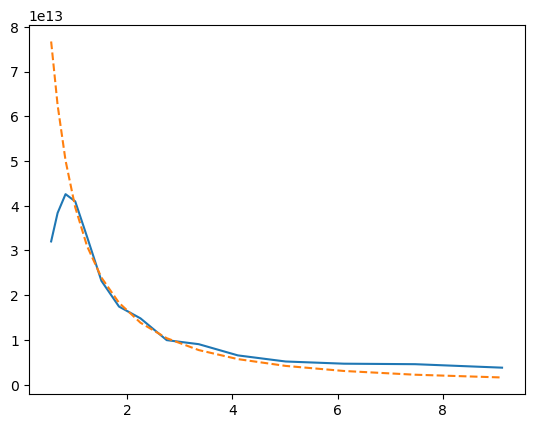

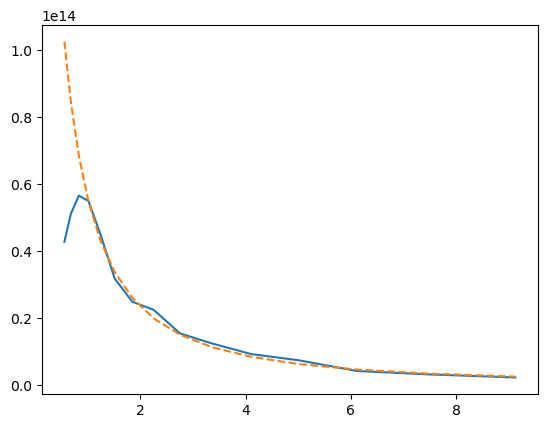

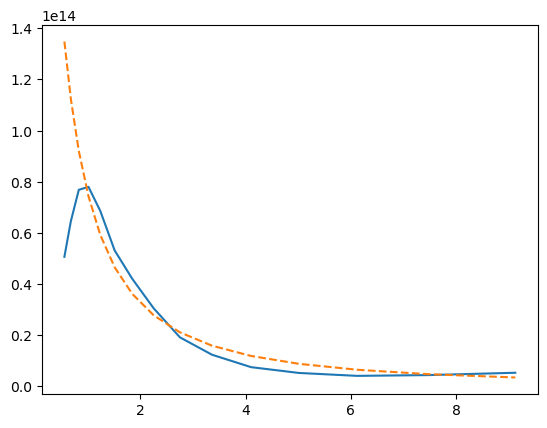

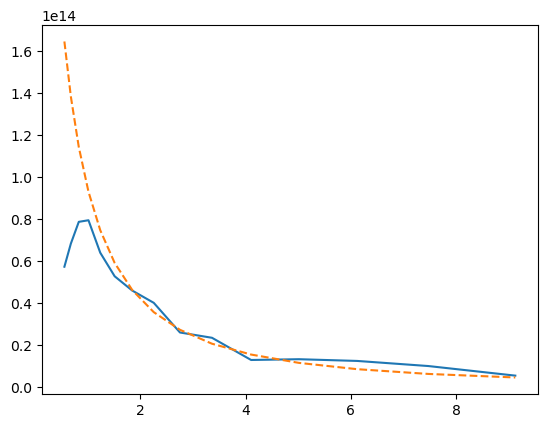

In [77]:
from crow import ClusterShearProfile
cl_delta_sigma = ClusterShearProfile(
    cosmo, hmf, is_delta_sigma=True, cluster_concentration=4.0
)

purity_aguena = purity_models.PurityAguena16()
completeness_aguena = completeness_models.CompletenessAguena16()
# zbins = []
# for i in range(0,6):
#     zbins.append((t1.get_tracer(f"bin_z_{i}").lower, (t1.get_tracer(f"bin_z_{i}").upper )))
# print(zbins)

z_bins_tuple = [(z_edges[i], z_edges[i+1]) for i in range(len(z_bins) -1)]
proxy_bins = [(l_edges[i], l_edges[i+1]) for i in range(len(richness_bins_linear) - 1)]
redshift_distribution = kernel.SpectroscopicRedshift()

# --- Fiducial grid with completeness & purity ---
recipe_grid_shear = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_delta_sigma,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_richness_unb,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
    purity=purity_aguena,
    completeness=completeness_aguena
)
recipe_grid_comp.setup()
print(z_bins_tuple)
grid_comp_vals  = np.zeros((len(z_bins)-1, len(richness_bins_linear)-1, len(radius_vals)))

data_matrix= np.zeros((len(z_bins)-1, len(richness_bins_linear)-1, len(radius_vals))) 
print(len(radius_vals))
for j in range(0,6):  # Third z-bin
    zbin = f'bin_z_{j}'
    # Begin loop over richness bins
    for rich_bin_index in range(4):
        rich_bin = f'bin_rich_{rich_bin_index}'
        color = cmap(rich_bin_index)  # Get consistent color per bin
    
        data_true = []
        data_true_error = []
    
        radius_vals = []
    
        for i in range(15):
            radius_key = f'radius_{i}'
            trac = ('cosmodc2_redmapper', rich_bin, zbin, radius_key)
            radius = t1.tracers[radius_key].center
            radius_vals.append(radius)
            data_matrix[j,rich_bin_index, i] = t1.get_data_points(sacc.data_types.standard_types.cluster_delta_sigma, trac)[0].value

for i, zb in enumerate(z_bins_tuple):
    for j, pb in enumerate(proxy_bins):
        counts = recipe_grid_shear.evaluate_theory_prediction_counts(np.array(zb), np.array(pb), sky_area)
        grid_comp_vals[i,j, :] = recipe_grid_shear.evaluate_theory_prediction_lensing_profile(np.array(zb), np.array(pb), np.array(radius_vals), sky_area, average_on=ClusterProperty.DELTASIGMA) / counts
        plt.plot(radius_vals, data_matrix[i,j,:], "-")
        plt.plot(radius_vals,grid_comp_vals[i,j, :], "--")
        plt.show()


In [63]:
def get_cluster_abundance() -> ClusterAbundance:
    """Creates and returns a ClusterAbundance object.""" 
    cluster_theory = ClusterAbundance(
    halo_mass_function = ccl.halos.MassFuncDespali16(mass_def="200c"),
    cosmo = ccl.CosmologyVanillaLCDM()
    )

    return cluster_theory


def get_cluster_shear_profile() -> ClusterShearProfile:
    """Creates and returns a ClusterShearProfile object."""
    cluster_theory = ClusterShearProfile(
    cosmo=ccl.CosmologyVanillaLCDM(),
    halo_mass_function = ccl.halos.MassFuncDespali16(mass_def="200c"),
    cluster_concentration=None,
    is_delta_sigma=True,
    use_beta_s_interp=True,
    two_halo_term=False,
    boost_factor=False,
    )

    return cluster_theory

def get_cluster_recipe(
    cluster_theory,
    pivot_mass: float = 14.3,
    pivot_redshift: float = 0.5,
    mass_interval=(12.0, 15.5),
    true_z_interval=(0.2, 0.8),
    is_reduced_shear = False,
):
    """Creates and returns a ClusterRecipe.

    Parameters
    ----------
    cluster_theory : ClusterShearProfile or ClusterAbundance
    """
    redshift_distribution = kernel.SpectroscopicRedshift()
    completeness = completeness_models.CompletenessAguena16()
    purity = purity_models.PurityAguena16()
    if is_reduced_shear:
        cluster_theory.set_beta_parameters(10.0, 5.0)
        cluster_theory.set_beta_s_interp(true_z_interval[0], true_z_interval[1])
    mass_distribution = mass_proxy.MurataUnbinned(
        pivot_log_mass=14.3,
        pivot_redshift=0.5,
    )

    recipe = GridBinnedClusterRecipe(
        redshift_grid_size = 20,
        mass_grid_size = 60,
        proxy_grid_size = 20,
        cluster_theory=cluster_theory,
        redshift_distribution=redshift_distribution,
        mass_distribution=mass_distribution,
        completeness=completeness,
        purity=purity,
        mass_interval=(12.0, 15.5),
        true_z_interval=(0.2, 0.8),
    )

    return recipe

recipe_counts = get_cluster_recipe(get_cluster_abundance())
recipe_shear = get_cluster_recipe(get_cluster_shear_profile(), is_reduced_shear = False)
recipe_shear.cluster_theory.cosmo = cosmo
recipe_shear.mass_distribution = mass_richness_unb
recipe_shear.cluster_theory.parameters["cluster_concentration"] = 4.0

[(np.float64(0.2), np.float64(0.3)), (np.float64(0.3), np.float64(0.4)), (np.float64(0.4), np.float64(0.5)), (np.float64(0.5), np.float64(0.6)), (np.float64(0.6), np.float64(0.7)), (np.float64(0.7), np.float64(0.8))]
15


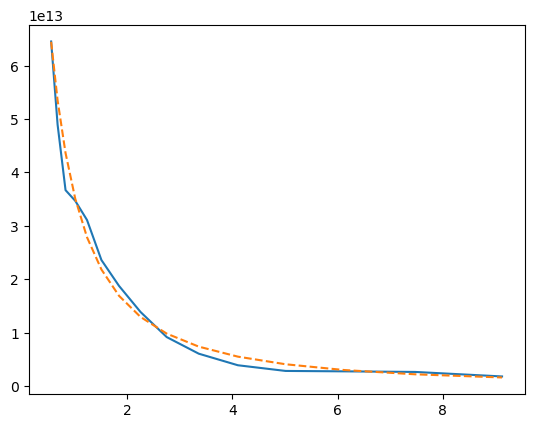

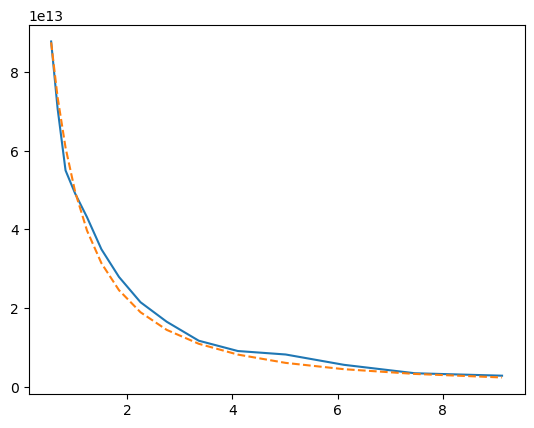

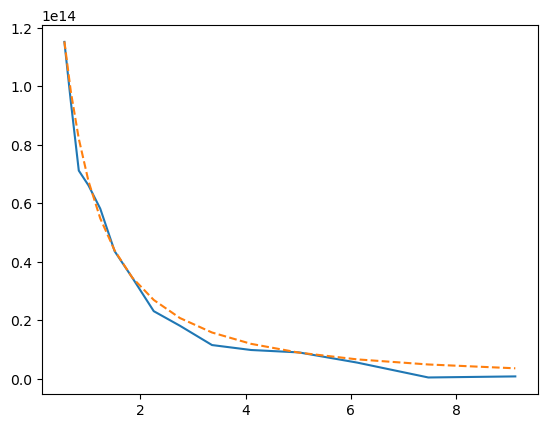

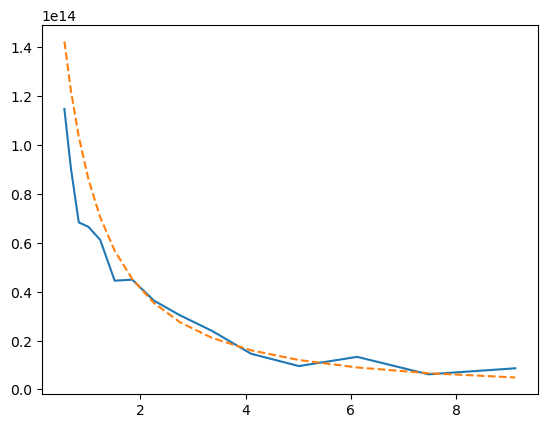

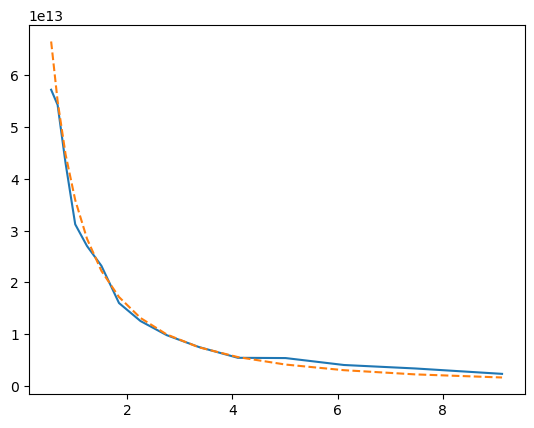

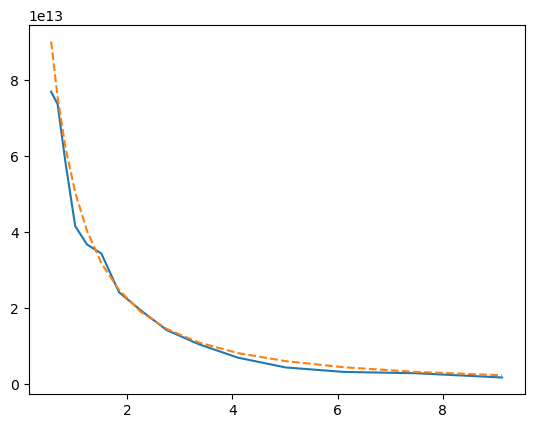

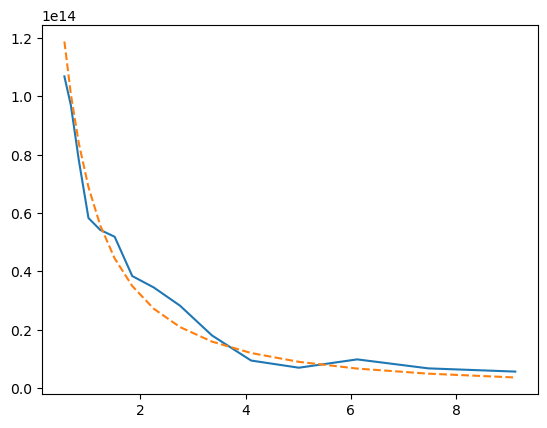

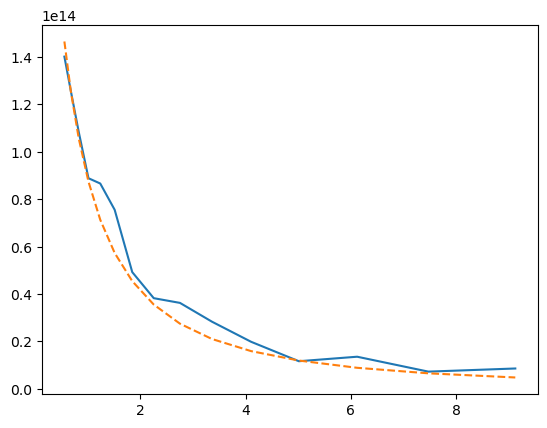

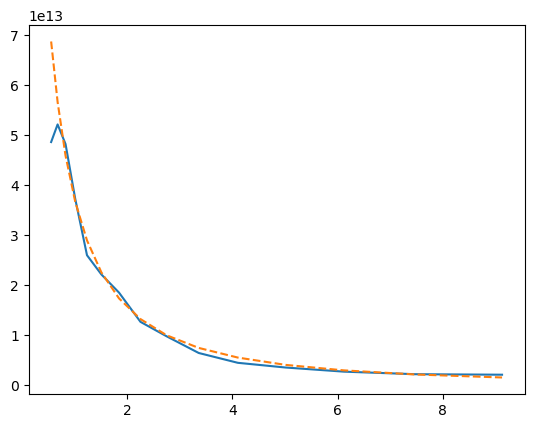

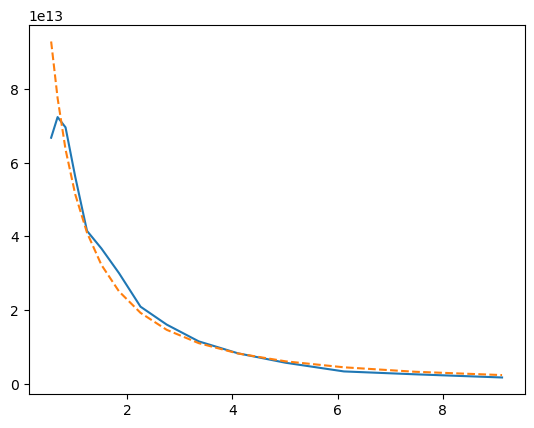

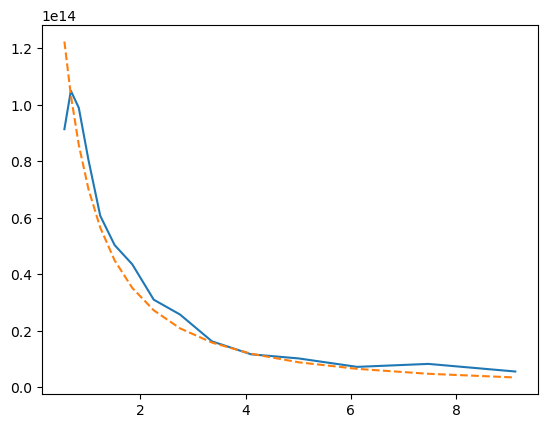

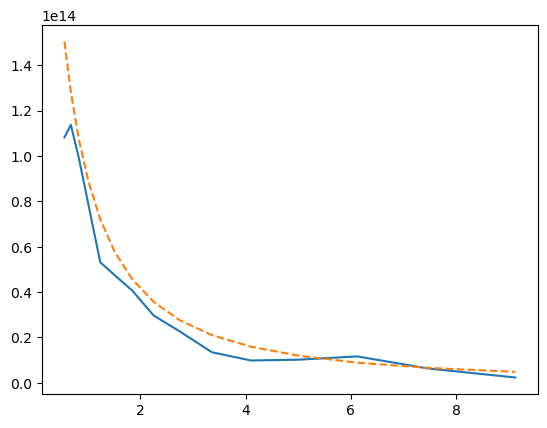

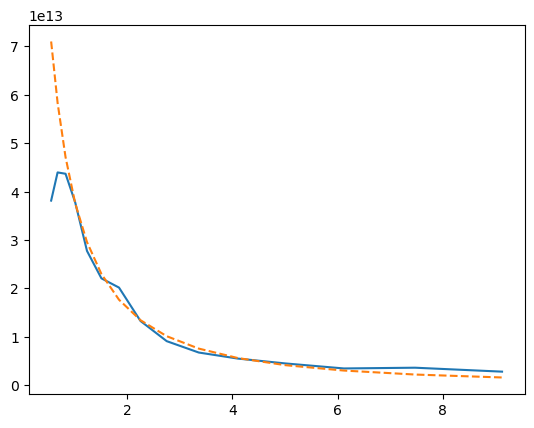

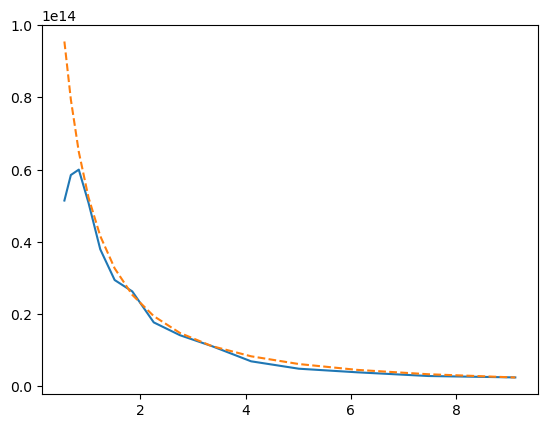

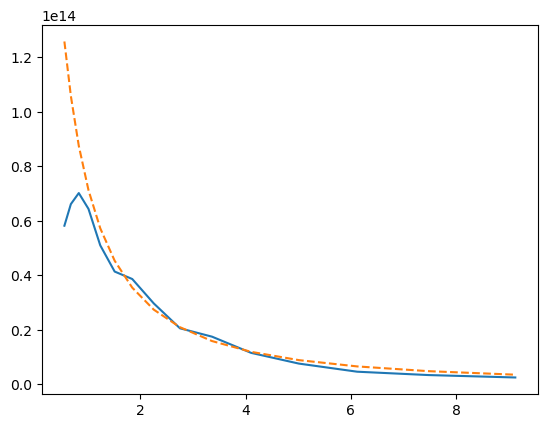

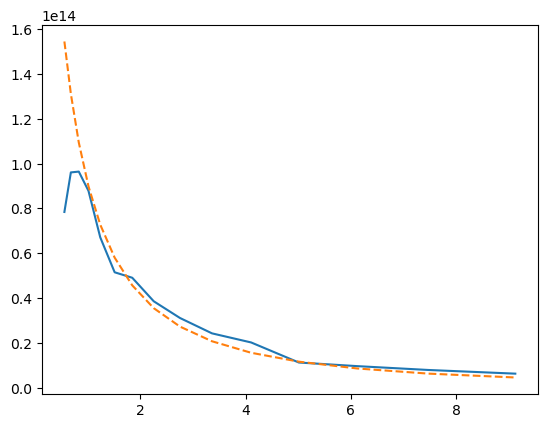

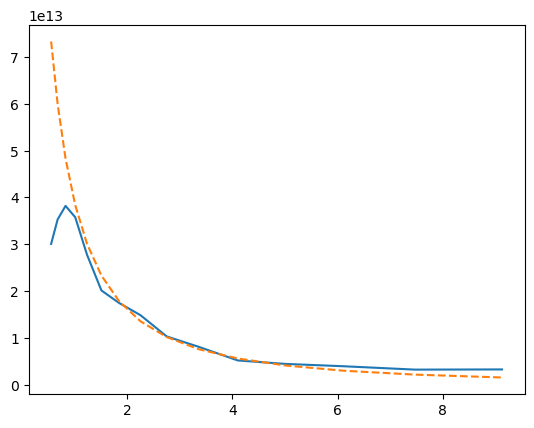

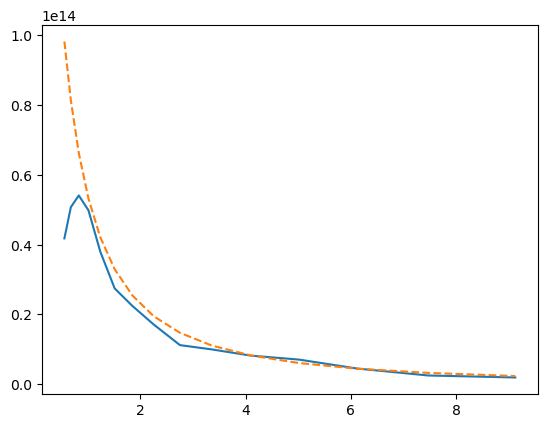

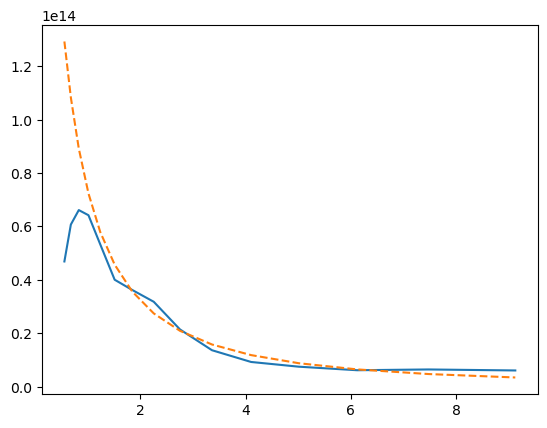

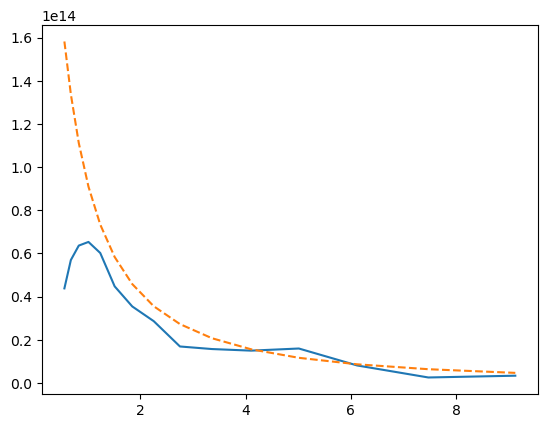

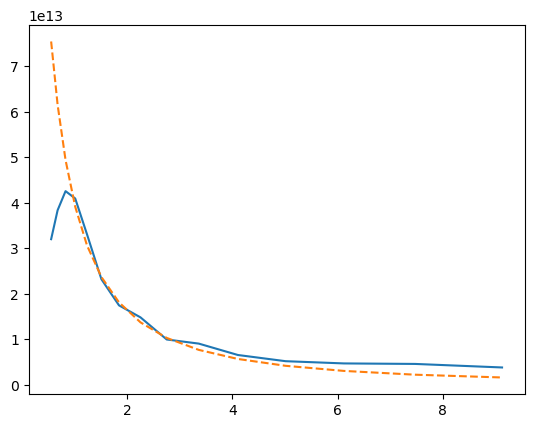

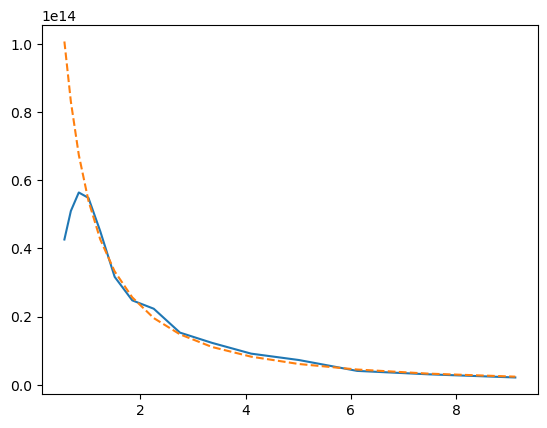

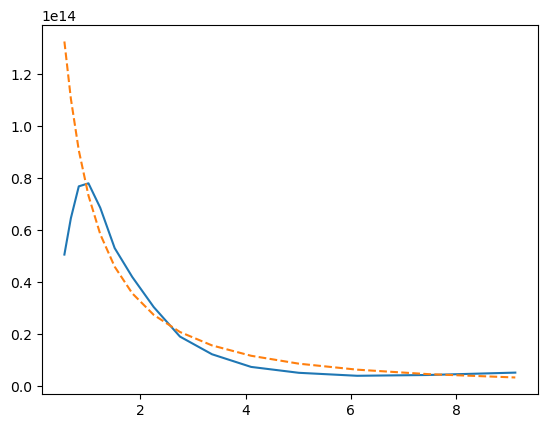

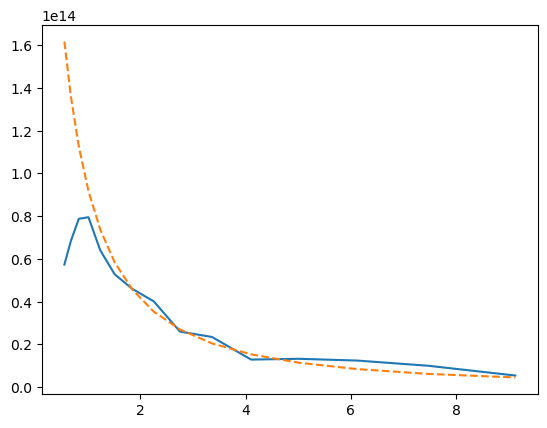

In [64]:
recipe_grid_shear = recipe_shear
recipe_grid_shear.setup()
print(z_bins_tuple)
grid_comp_vals  = np.zeros((len(z_bins)-1, len(richness_bins_linear)-1, len(radius_vals)))

data_matrix= np.zeros((len(z_bins)-1, len(richness_bins_linear)-1, len(radius_vals))) 
print(len(radius_vals))
for j in range(0,6):  # Third z-bin
    zbin = f'bin_z_{j}'
    # Begin loop over richness bins
    for rich_bin_index in range(4):
        rich_bin = f'bin_rich_{rich_bin_index}'
        color = cmap(rich_bin_index)  # Get consistent color per bin
    
        data_true = []
        data_true_error = []
    
        radius_vals = []
    
        for i in range(15):
            radius_key = f'radius_{i}'
            trac = ('cosmodc2_redmapper', rich_bin, zbin, radius_key)
            radius = t1.tracers[radius_key].center
            radius_vals.append(radius)
            data_matrix[j,rich_bin_index, i] = t1.get_data_points(sacc.data_types.standard_types.cluster_delta_sigma, trac)[0].value

for i, zb in enumerate(z_bins_tuple):
    for j, pb in enumerate(proxy_bins):
        counts = recipe_grid_shear.evaluate_theory_prediction_counts(np.array(zb), np.array(pb), sky_area)
        grid_comp_vals[i,j, :] = recipe_grid_shear.evaluate_theory_prediction_lensing_profile(np.array(zb), np.array(pb), np.array(radius_vals), sky_area, average_on=ClusterProperty.DELTASIGMA) / counts
        plt.plot(radius_vals, data_matrix[i,j,:], "-")
        plt.plot(radius_vals,grid_comp_vals[i,j, :], "--")
        plt.show()
